In [1]:
import pip

def install(package):
    if hasattr(pip, 'main'):
        pip.main(['install', package])
    else:
        pip._internal.main(['install', package])

In [3]:
install('librosa')

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
install('jiwer')

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import io
!pip install librosa
!pip install jiwer
#!pip install pytorch

    100% |████████████████████████████████| 1.6MB 705kB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 1.9MB/s ta 0:00:011
    100% |████████████████████████████████| 327kB 1.2MB/s ta 0:00:011
    100% |████████████████████████████████| 3.2MB 371kB/s eta 0:00:01
    100% |████████████████████████████████| 16.1MB 72kB/s  eta 0:00:01   15% |█████                           | 2.5MB 6.4MB/s eta 0:00:03    46% |██████████████▉                 | 7.5MB 13.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audiore

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy
import os
import torch
#from torch.nn import CTCLoss
from warpctc_pytorch import CTCLoss
from ctcdecode import CTCBeamDecoder
import itertools
#import jiwer
import random
import scipy

In [3]:
#Functions for file manipulation
def load_samples(file_path):
    ys, srs = [[]],[[]]
    i = 0
    #loads .wav files
    for filename in os.listdir(file_path):
        if filename.endswith(".wav"):
            y, sr = librosa.load(file_path+filename, sr=16000)
            ys[i].append(y)
            srs[i].append(sr)
            i = i + 1
            ys.append([])
            srs.append([])
        if i > 600:
            break
    ys = ys[0: len(ys) - 1]
    srs = srs[0: len(srs) - 1]
    return (ys, srs)


def load_labels(file_path):
    i = 0
    labels = [[]]
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            file = open(file_path+filename, "r") 
            labels[i].append(file.read())
            labels.append([])
            i = i + 1
            
    labels=labels[0: len(labels) - 1]
    return labels

In [4]:
#Functions for feature extraction
def find_max(ys):
    """
    Searches for the longest same.
    used for padding.
    ys - [num_samples] x [sample_length]
    
    returns
    max(sample_length)
    """
    
    maximum =0
    for y1 in ys:
        for y2 in y1:
            dim = y2.shape[0]
            if dim > maximum:
                maximum = dim
    return maximum

def pad_signal(ys, max_length):
    """
    pads the signal
    
    Signals are not of the same length, so samples that are shorter then longest signal are padded
    ys - [num_samples] x [sample_length]
    
    returns
    [num_samples] x [sample_length] - sample_length is now same for each sample
    """
    
    
    ys_new = ys
    for i, y1 in enumerate(ys_new):
        for j, y2 in enumerate(y1):
            if len(y2) < max_length:
                z = numpy.zeros((max_length - len(y2)))
                paded_signal = numpy.append(y2, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
                ys_new[i][j] = paded_signal
    return ys_new
def pre_emphasize(ys, pre_emphasis = 0.97):
    """
    Performs pre emphasis
    
    ys - ys - input array of all samples [num_samples] x [sample_length]
    pre_emphasis - pre emphasis factor, usually 0.97
    
    returns
    [num_samples] x [sample_length] - emphasized signal
    """
    for i, y in enumerate(ys):
        signal=y[0]
        ### bug down there: you update variable that is temporary. , maybe not becasue it is indicator, but still. 
        y[0] = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return ys
def fourier_transform(ys, N_FFT=512, window='hamming', hop_size=256):
    """
    Performs stft
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    window - window function - e.g. hanning, or hamming etc.
    hop_size - self explanatory
    
    returns Ds [num_samples] x [1] x [sequence_length] x [N_FFT/2 + 1] - returns spectrogram of the sample. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ... 
    
    """
    
    Ds = [[]]

    for i, y in enumerate(ys):
        Ds[i].append(librosa.core.stft(y=y[0], n_fft=N_FFT, window=window, hop_length=hop_size))
        Ds.append([])
    return Ds

def mfccs(ys, N_FFT=512, sr=16000, n_mfcc=40, hop_size=256):
    """
    Extracts mel features
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    sr - sampling rate
    n_mfcc - number of mfcc features
    hop_size - self explanatory
    
    returns
    mels [num_samples] x [1] x [sequence_length] x [n_mfcc] - returns mel features. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ...
    """
    mels = [[]]
    
    for i, y in enumerate(ys):
        mels[i].append(librosa.feature.mfcc(y[0], sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=hop_size))
        mels.append([])
    return mels


def to_frames(ys, frame_length = 25, hop_length = 10):
    
    frames = [[]]
    
    for i, y in enumerate(ys):
        frames[i].append(librosa.util.frame(y[0], frame_length=frame_length, hop_length=hop_length))
        frames.append([])
    return frames



In [5]:
def display_cost(costs, num_epochs):
    print(len(costs))
    x = numpy.arange(0, num_epochs, 1)
    print(len(x))
    print(num_epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(x, costs)
    plt.show()
    

def greedy_decoder(outs, all_labels):
    """
    """
    
    outputs=outs
    string=[]
    maximals, indices = outputs.max(1)
    for i in indices:
        string.append(all_labels[i])
    itertools.groupby(string)
    string=[k for k, g in itertools.groupby(string)]
    output =[]
    for s in string:
        if s != "-":
            output.append(s)
    
    print(output)
    return output

def WER(predicted, ground_truth):
    arr=numpy.zeros([len(predicted) + 1, len(ground_truth) + 1])
    
    
    i = 0
    while i < len(arr):
        j = 0
        
        while j < len(arr[i]):
            if i == 0:
                arr[0][j] = j
            elif j == 0:
                arr[i][0] = i
    
            j = j + 1
        i = i + 1
        
    i = 1
    while i < len(arr):
        
        j = 1
        while j < len(arr[i]):
            if predicted[i - 1] == ground_truth[j - 1]:
                arr[i][j] = arr[i - 1][j - 1]
            else:
                replace = arr[i-1][j-1] + 1
                insert  = arr[i][j-1]   + 1
                delete  = arr[i-1][j]   + 1
                arr[i][j]=min(replace, insert, delete)
            j = j + 1
        i = i + 1
    
    return arr[len(predicted)][len(ground_truth)]/len(predicted.split())
    

In [6]:
def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [7]:
def ler_extended(ref, hyp ,debug=False):
    r = list(ref)
    h = list(hyp)
    #costs will holds the costs, like in the Levenshtein distance algorithm
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    # backtrace will hold the operations we've done.
    # so we could later backtrace, like the WER algorithm requires us to.
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
 
    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3
    
    SUB_PENALTY = 1
    INS_PENALTY = 1
    DEL_PENALTY = 1
     
    # First column represents the case where we achieve zero
    # hypothesis words by deleting all reference words.
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL
         
    # First row represents the case where we achieve the hypothesis
    # by inserting all hypothesis words into a zero-length reference.
    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS
     
    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY # penalty is always 1
                insertionCost    = costs[i][j-1] + INS_PENALTY   # penalty is always 1
                deletionCost     = costs[i-1][j] + DEL_PENALTY   # penalty is always 1
                 
                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL
                 
    # back trace though the best route:
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("#cor " + str(numCor))
        print("#sub " + str(numSub))
        print("#del " + str(numDel))
        print("#ins " + str(numIns))
    #return (numSub + numDel + numIns) / (float) (len(r))
    if len(r) == 0:
        r = str(1)
    wer_result = round( (numSub + numDel + numIns) / (float) (len(r)), 3)
    
    return {'Total absolute':(numSub + numDel + numIns),'WER':wer_result, 'Correct':numCor, 'Sub':numSub, 'Ins':numIns, 'Del':numDel}

In [8]:
# check WER:
print(WER("who is there", "is there"))
# validate with wer:
print(wer("who is there".split(), "is there".split()))
# check number of del, add, and so on
print(ler_extended("who is there", "is there"))
# check WER:
print(WER("who is there", ""))
# validate with wer:
print(wer("who is there".split(), "".split()))

print(ler_extended("who is there", ""))

# check WER:
print(WER("","who is there"))
# validate with wer:
print(wer( "".split(),"who is there".split()))

print(ler_extended("who is there", "is there"))


1.3333333333333333
1
{'Total absolute': 4, 'WER': 0.333, 'Correct': 8, 'Sub': 0, 'Ins': 0, 'Del': 4}
4.0
3
{'Total absolute': 12, 'WER': 1.0, 'Correct': 0, 'Sub': 0, 'Ins': 0, 'Del': 12}
inf
3
{'Total absolute': 4, 'WER': 0.333, 'Correct': 8, 'Sub': 0, 'Ins': 0, 'Del': 4}


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


# Step 1
* we open the samples and labels

In [9]:
path = "an4_dataset/train/"#path to the dataset

ys, srs = load_samples(path)
labels = load_labels(path)

In [10]:
path2 = "an4_dataset/validation/"

ys_valid, srs = load_samples(path2)
labels_valid = load_labels(path2)

# Step 2
* loaded data is preprocessed
* we perform stft using librosa
* then we add melspectrogram
* and MFCCs, all are prepared, but we can use each of them, so we get different kinds of features

**Note**: For stft we have a window size, typically 512 or 256 and hop size. On each iteration we start at 
$$
n_1 = N_f x H
$$
and we finish at
$$
n_2 = n_1 + M - 1
$$

https://dsp.stackexchange.com/questions/38491/time-position-in-stft-output

H is a hop size (length) and M is a window size.

In [11]:
train_max=find_max(ys=ys)
valid_max=find_max(ys=ys_valid)
max_len= train_max if train_max>valid_max else valid_max

print(type(ys))
print(type(ys_valid))
print(ys[0][0].shape)
ys_new = pad_signal(ys, max_len)
ys_valid_new=pad_signal(ys_valid, max_len)

ys_emphasized=pre_emphasize(ys_new, 0.97)
ys_valid_emphasize=pre_emphasize(ys_valid_new, 0.97)

<class 'list'>
<class 'list'>
(24000,)


In [12]:
ys_emphasized[947][0].shape

IndexError: list index out of range

In [13]:
def cut_audio_into_frames(ys_emphasized, max_len,  sample_rate=16000, frame_size = 0.025, frame_stride = 0.01  ):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    rawSamples = list()
    #loads .wav files
    sam_no = 0
    for sam_no, audio in enumerate(ys_emphasized):
        signal = audio[0]
            #sig = [[signal]]
        # it is already signal_new=pad_signal(signal, max_len)
        signal_length = len(signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
            
        pad_signal_length = num_frames * frame_step + frame_length
        z = numpy.zeros((pad_signal_length - signal_length))
        pad_signal_numbers = numpy.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
            
        indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal_numbers[indices.astype(numpy.int32, copy=False)]
        rawSamples.append(frames)
        #if(sam_no > 399):
        #    break
            
           #sample_rate, signal = scipy.io.wavfile.read(path+filename)  # File assumed to be in the same directory
           #signal = signal[0:int(3.5 * sample_rate)] 
           #pre_emphasis = 0.97
           #emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
           #frame_size, frame_stride = 0.02, 0.01
           #frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
           #signal_length = len(emphasized_signal)
           #frame_length = int(round(frame_length))
           #frame_step = int(round(frame_step))
           #num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

           #pad_signal_length = num_frames * frame_step + frame_length
           #z = numpy.zeros((pad_signal_length - signal_length))
           #pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

           #indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
           #frames = pad_signal[indices.astype(numpy.int32, copy=False)]
           #frames *= numpy.hamming(frame_length)
    return rawSamples


In [14]:
raw_wave_frames = cut_audio_into_frames(ys_emphasized, max_len= max_len, sample_rate= 16000)

In [15]:
len(raw_wave_frames)

601

In [16]:
sam = raw_wave_frames[0]

In [17]:
sam.shape

(638, 400)

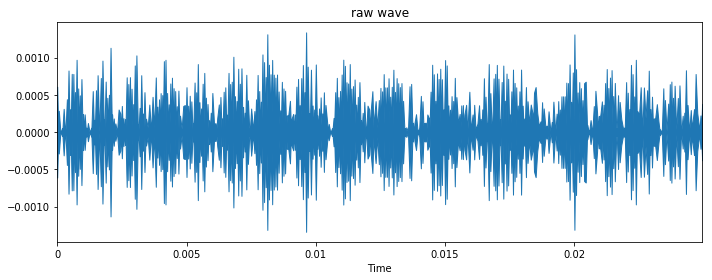

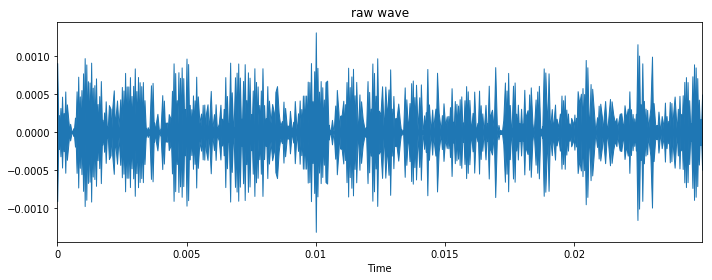

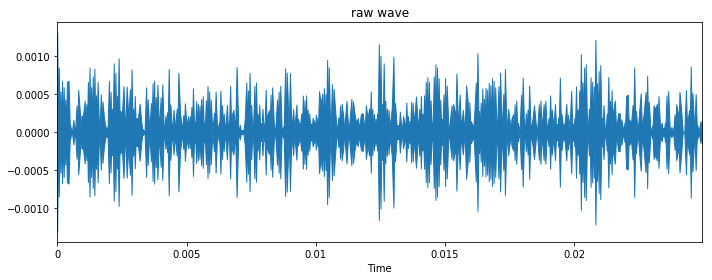

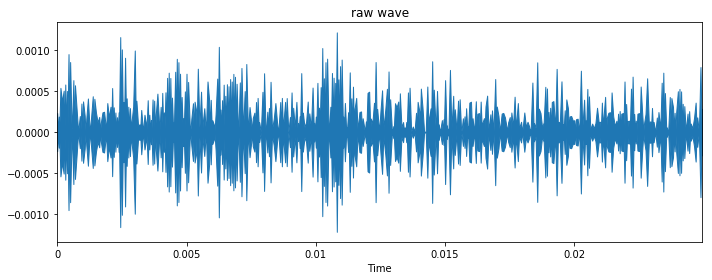

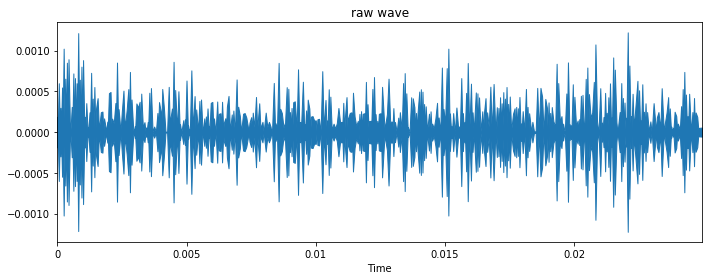

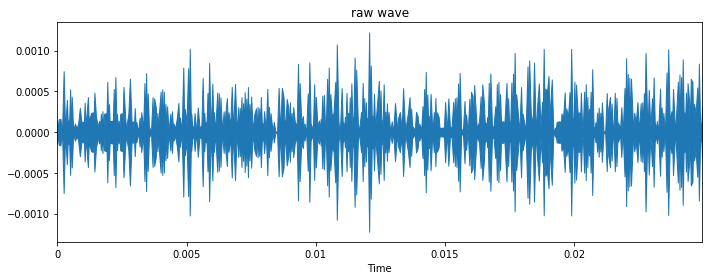

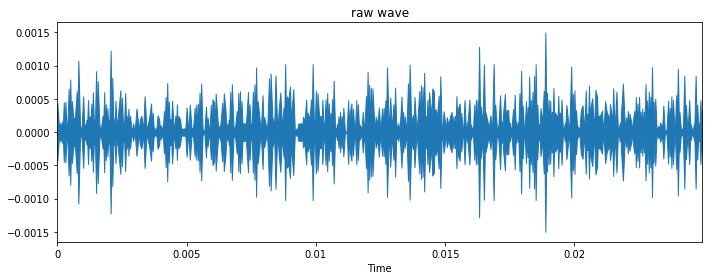

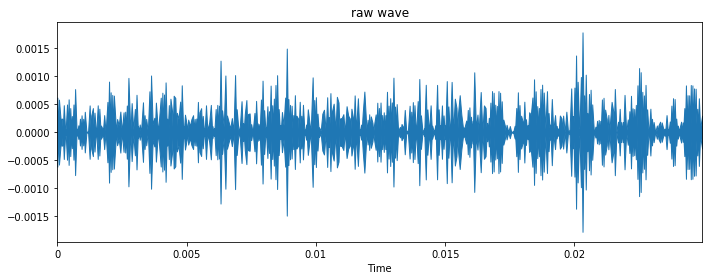

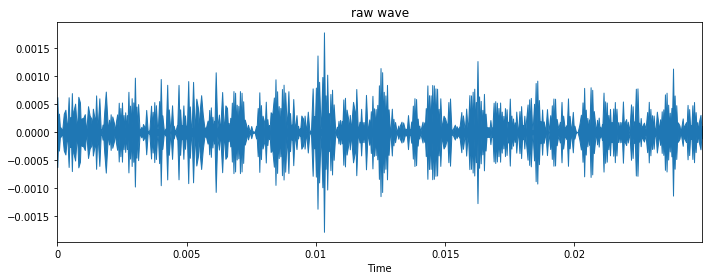

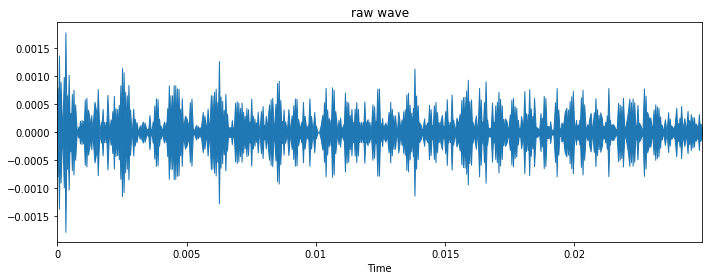

In [18]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
for i in range(10):
    plt.figure(figsize=(10, 4))

#>>> plt.figure()
#>>> plt.subplot(3, 1, 1)
#librosa.display.waveplot(frameg[3] , x_axis='time')

    librosa.display.waveplot(numpy.array(sam[i]), sr=16000, x_axis='time')
#plt.colorbar()
    plt.title('raw wave')
    plt.tight_layout()


In [ ]:
arange(0.0, 1.0, 0.01)

In [19]:
len(ys_emphasized)

601

In [127]:
# it seems does not work
def to_frames(ys, frame_length = 25, hop_length = 10):
    
    frames = [[]]
    
    for i, y in enumerate(ys):
        frames[i].append(librosa.util.frame(y[0], frame_length=frame_length, hop_length=hop_length))
        frames.append([])
    return frames

In [20]:
N_FFT = 400 #window size
window = 'hamming'
hop_size = 160
window_size = 400
N_MFCC = 40

#raw_wave_frames = to_frames(ys = ys_new , frame_length = window_size, hop_length = 1 )
#Ds=fourier_transform(ys=ys_emphasized, N_FFT=N_FFT, window=window, hop_size=hop_size)
#Ms=mfccs(ys=ys_emphasized, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)
#Ms_valid=mfccs(ys=ys_valid_emphasize, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size) 
raw_valid =  cut_audio_into_frames(ys_valid_emphasize, max_len= max_len, sample_rate= 16000   ) 

In [21]:
print(raw_wave_frames[0][0].shape )
frameg = raw_wave_frames[0][0]
frameg = frameg.reshape((102001, 400))
frameg.shape
#print(raw_wave_frames[0][0].shape)

(400,)


ValueError: cannot reshape array of size 400 into shape (102001,400)

In [132]:
frameg.shape

(102001, 400)

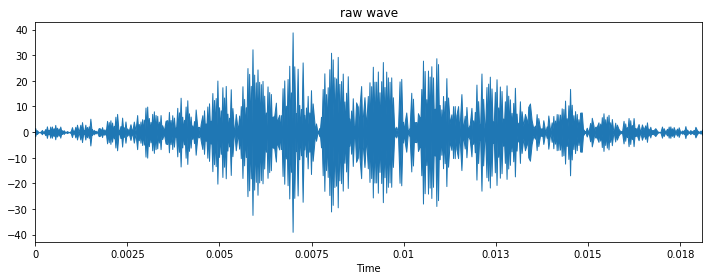

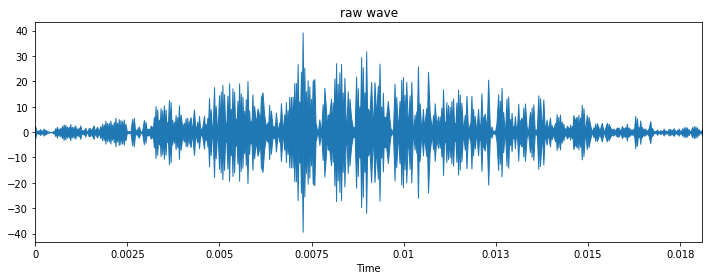

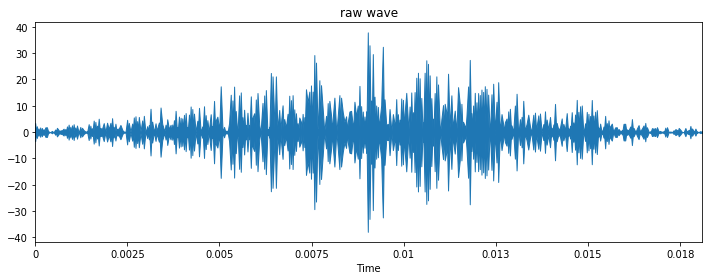

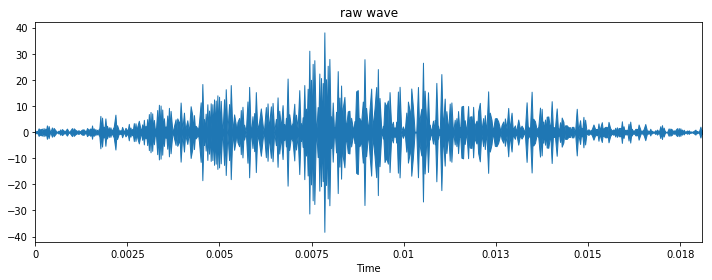

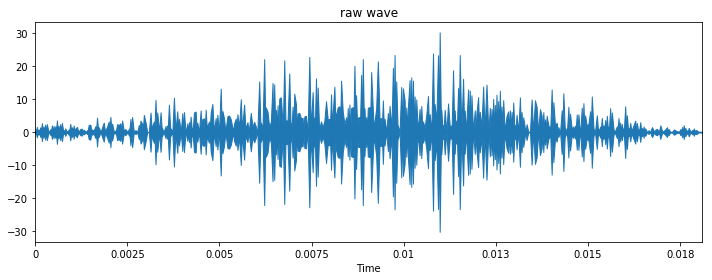

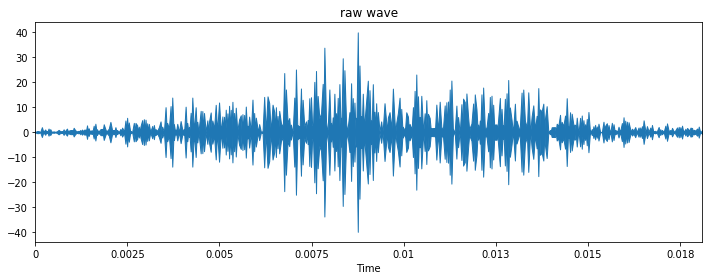

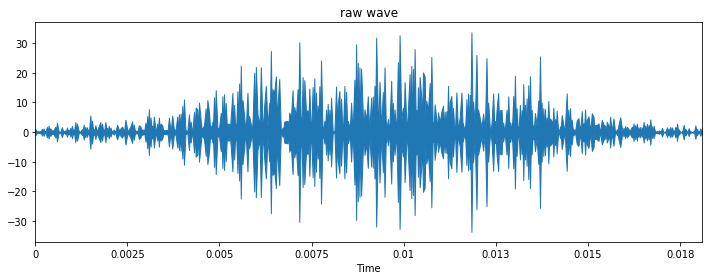

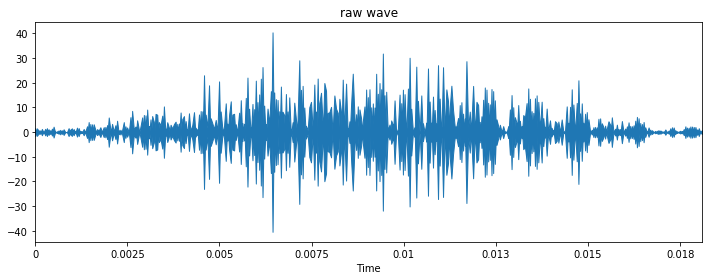

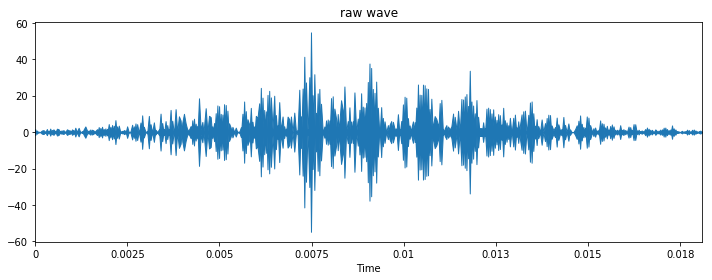

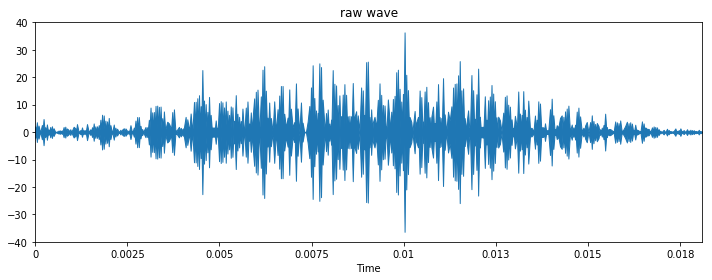

In [137]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
for i in range(10):
    plt.figure(figsize=(10, 4))

#>>> plt.figure()
#>>> plt.subplot(3, 1, 1)
#librosa.display.waveplot(frameg[3] , x_axis='time')

    librosa.display.waveplot(numpy.array(frames[i]), x_axis='time')
#plt.colorbar()
    plt.title('raw wave')
    plt.tight_layout()


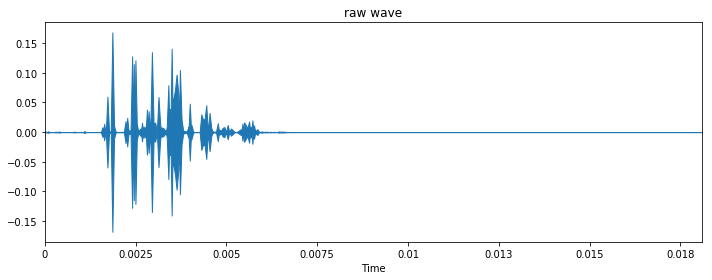

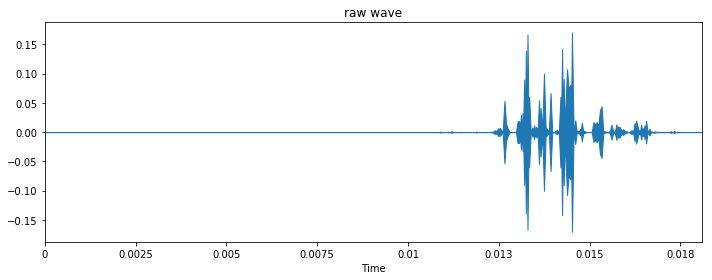

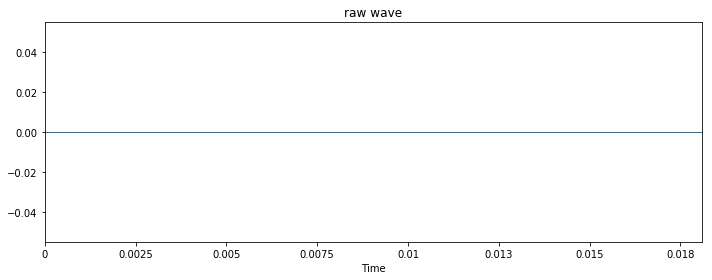

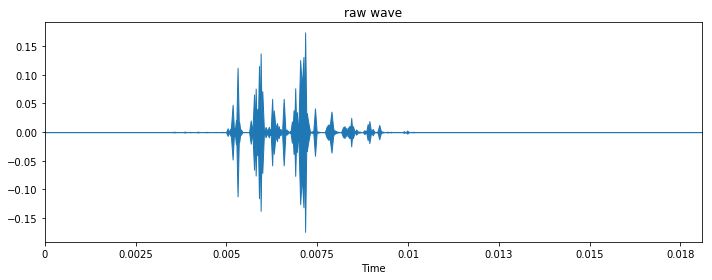

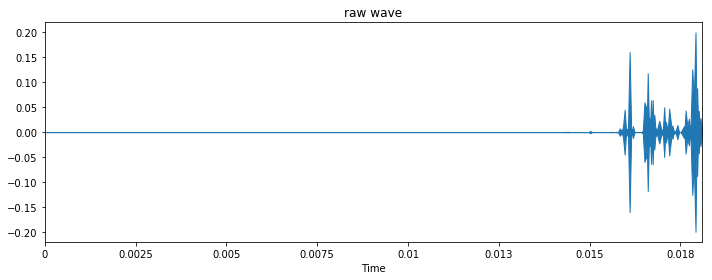

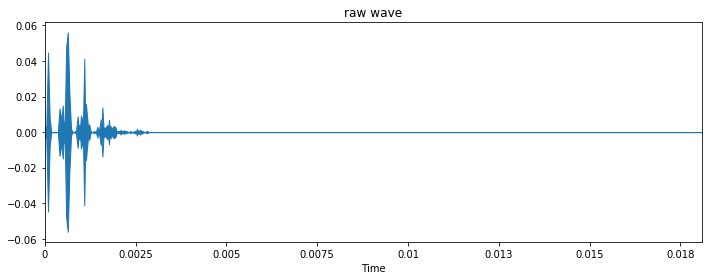

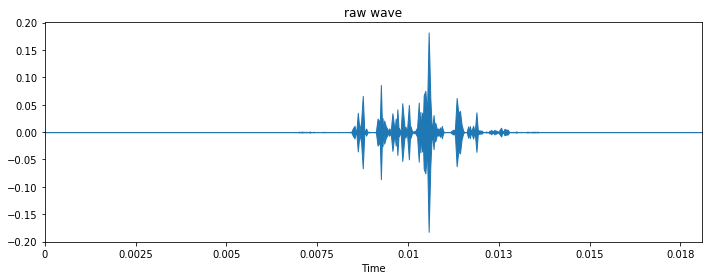

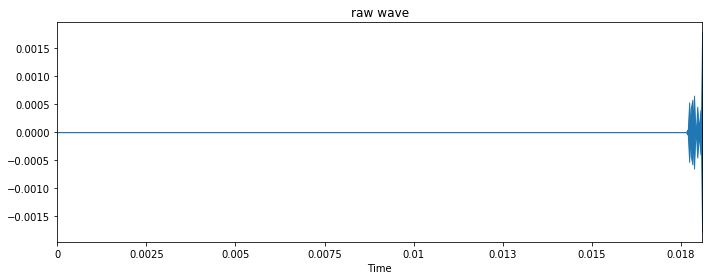

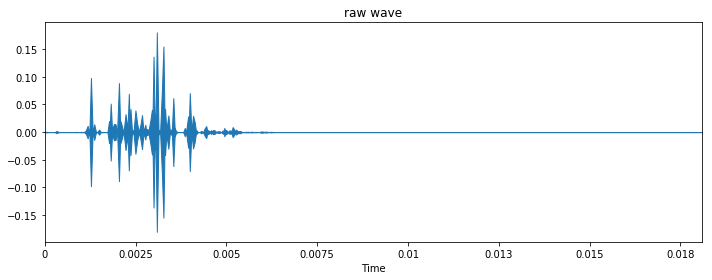

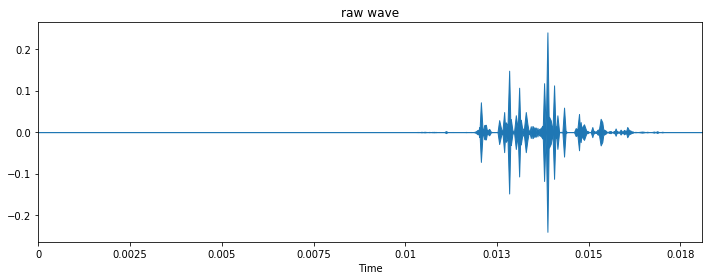

In [108]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
for i in range(10):
    plt.figure(figsize=(10, 4))

#>>> plt.figure()
#>>> plt.subplot(3, 1, 1)
#librosa.display.waveplot(frameg[3] , x_axis='time')

    librosa.display.waveplot(numpy.array(frameg[i]), x_axis='time')
#plt.colorbar()
    plt.title('raw wave')
    plt.tight_layout()


# Step 3

Here we create a neural network, define loss function (CTCLoss in our case) and optimizer.

In [22]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool1d, Dropout2d, Conv1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [28]:
# hyperameters of the model
num_classes = 28
channels = 400
height = 638
#width = 40

num_filters_conv1 = 96
kernel_size_conv1 = 7 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0
dilation_conv1 = 1


stride_pool1 = 2
kernel_size_pool1 = 2
padding_pool1 = 0
dilation_pool1 = 1

#convolutional layer
num_filters_conv2 = 128
kernel_size_conv2 = 5 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 0
dilation_conv2 = 1

stride_pool2 = 2
kernel_size_pool2 = 2
padding_pool2 = 0
dilation_pool2 = 1

#3rd convolutional layer
num_filters_conv3 = 64
kernel_size_conv3 = 3 # [height, width]
stride_conv3 = 1 # [stride_height, stride_width]
padding_conv3 = 0
dilation_conv3 = 1

stride_pool3 = 2
kernel_size_pool3 = 2
padding_pool3 = 0
dilation_pool3 = 1

#4th convolutional layer
num_filters_conv4 = 32
kernel_size_conv4 = 3 # [height, width]
stride_conv4 = 1 # [stride_height, stride_width]
padding_conv4 = 0
dilation_conv4 = 1

#5th convolutional layer
num_filters_conv5 = 64
kernel_size_conv5 = 5 # [height, width]
stride_conv5 = 1 # [stride_height, stride_width]
padding_conv5 = 0
dilation_conv5 = 1

#6th convolutional layer
num_filters_conv6 = 64
kernel_size_conv6 = 3 # [height, width]
stride_conv6 = 1 # [stride_height, stride_width]
padding_conv6 = 0
dilation_conv6 = 1

#7th convolutional layer
num_filters_conv7 = 64
kernel_size_conv7 = 3 # [height, width]
stride_conv7 = 1 # [stride_height, stride_width]
padding_conv7 = 0
dilation_conv7 = 1



#8th convolutional layer
num_filters_conv8 = 32
kernel_size_conv8 = 1 # [height, width]
stride_conv8 = 1 # [stride_height, stride_width]
padding_conv8 = 0
dilation_conv8 = 1

#9th convolutional layer
num_filters_conv9 = 32
kernel_size_conv9 = (1,1) # [height, width]
stride_conv9 = (1, 1) # [stride_height, stride_width]
padding_conv9 = (0,0)
dilation_conv9 = (1,1)


#10th convolutional layer
num_filters_conv10 = 32
kernel_size_conv10 = (1,1) # [height, width]
stride_conv10 = (1, 1) # [stride_height, stride_width]
padding_conv10 = (0,0)
dilation_conv10 = (1,1)

batch_size=1
num_l1 = 512
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)


def compute_conv_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)

def compute_conv_height_2d(H_in, kernel_size_height, padding_height=0, dilation_height=1, stride_height=1):
    return int((H_in+2*padding_height-dilation_height*(kernel_size_height - 1) - 1)/stride_height + 1)

def compute_conv_width_2d(W_in,  kernel_size_width, padding_width=0, dilation_width=1, stride_width=1):
    return int((W_in+2*padding_width-dilation_width*(kernel_size_width-1) - 1)/stride_width + 1)

def compute_pool_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)
    
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim + 2 * padding) / stride + 1
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1,
                             dilation=dilation_conv1)
        
        
        
        self.conv_dim_1=compute_conv_dim_1d(L_in=height, kernel_in=kernel_size_conv1,padding_in=padding_conv1,
                        dilation_in=dilation_conv1, stride_in=stride_conv1)
        self.conv_dropout_1=torch.nn.Dropout2d(p=0.4)
        #self.conv_batchnorm_1=torch.nn.BatchNorm2d(num_filters_conv1)
        
        self.conv_2 = Conv1d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2,
                             dilation=dilation_conv2)
        
        
        
        
       
        self.conv_dim_2=compute_conv_dim_1d(L_in=self.conv_dim_1, kernel_in=kernel_size_conv2,padding_in=padding_conv2,
                        dilation_in=dilation_conv2, stride_in=stride_conv2)
        
        
        self.conv_dropout_2=torch.nn.Dropout2d(p=0.2)
        #self.conv_batchnorm_2=torch.nn.BatchNorm2d(num_filters_conv2)
        
        self.conv_3 = Conv1d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3,
                             padding=padding_conv3,
                             dilation=dilation_conv3)
        
        
        self.conv_dim_3=compute_conv_dim_1d(L_in=self.conv_dim_2, kernel_in=kernel_size_conv3,padding_in=padding_conv3,
                        dilation_in=dilation_conv3, stride_in=stride_conv3)
        
        
      
        
        self.conv_dropout_3=torch.nn.Dropout2d(p=0.1)
        #self.conv_batchnorm_3=torch.nn.BatchNorm2d(num_filters_conv3)
        
        self.conv_4 = Conv1d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4,
                             padding=padding_conv4,
                             dilation=dilation_conv4)
        
        
        
        
        self.conv_dim_4=compute_conv_dim_1d(L_in=self.conv_dim_3, kernel_in=kernel_size_conv4,padding_in=padding_conv4,
                        dilation_in=dilation_conv4, stride_in=stride_conv4)
        
        self.conv_dropout_4=torch.nn.Dropout2d(p=0.05)
        
        
        self.conv_5 = Conv1d(in_channels=num_filters_conv4,
                             out_channels=num_filters_conv5,
                             kernel_size=kernel_size_conv5,
                             stride=stride_conv5,
                             padding=padding_conv5,
                             dilation=dilation_conv5)
        
        self.conv_dim_5=compute_conv_dim_1d(L_in=self.conv_dim_4, kernel_in=kernel_size_conv5,padding_in=padding_conv5,
                        dilation_in=dilation_conv5, stride_in=stride_conv5)
          
        
        self.conv_6 = Conv1d(in_channels=num_filters_conv5,
                             out_channels=num_filters_conv6,
                             kernel_size=kernel_size_conv6,
                             stride=stride_conv6,
                             padding=padding_conv6,
                             dilation=dilation_conv6)
        
        self.conv_dim_6=compute_conv_dim_1d(L_in=self.conv_dim_5, kernel_in=kernel_size_conv6,padding_in=padding_conv6,
                        dilation_in=dilation_conv6, stride_in=stride_conv6)
        
        self.conv_7 = Conv1d(in_channels=num_filters_conv6,
                             out_channels=num_filters_conv7,
                             kernel_size=kernel_size_conv7,
                             stride=stride_conv7,
                             padding=padding_conv7,
                             dilation=dilation_conv7)
        
        self.conv_dim_7 = compute_conv_dim_1d(L_in=self.conv_dim_6, kernel_in=kernel_size_conv7,padding_in=padding_conv7,
                        dilation_in=dilation_conv7, stride_in=stride_conv7)
          
        
        self.conv_8 = Conv1d(in_channels=num_filters_conv7,
                             out_channels=num_filters_conv8,
                             kernel_size=kernel_size_conv8,
                             stride=stride_conv8,
                             padding=padding_conv8,
                             dilation=dilation_conv8)
        
        self.conv_dim_8 = compute_conv_dim_1d(L_in=self.conv_dim_7, kernel_in=kernel_size_conv8,padding_in=padding_conv8,
                        dilation_in=dilation_conv8, stride_in=stride_conv8)
          
        
        #self.conv_batchnorm_4=torch.nn.BatchNorm2d(num_filters_conv4)
        
        
        
        self.l1_in_features = num_filters_conv8
        #self.l1_in_features = channels * height * width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x, test = False): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(641, 1, 40)
        x = self.conv_1(x)
        x = self.conv_poool(x)
        x = relu(x)
        #x = relu(self.conv_1(x))
        #x = self.conv_dropout_1(x)
        #x = self.conv_batchnorm_1(x)
        #torch.Size([641, 16, 38])
        #x = self.maxPool_1(x)
        #([641, 16, 19])
        x = relu(self.conv_2(x))
        #x = self.conv_dropout_2(x)
        #x = self.conv_batchnorm_2(x)
        #print(x.shape)
        #x = self.maxPool_2(x)
        
        x = relu(self.conv_3(x))
        ##x = self.conv_dropout_3(x)
        #x = self.conv_batchnorm_3(x)
        
        x = relu(self.conv_4(x))
        ##x = self.conv_dropout_4(x)
        
        x = relu(self.conv_5(x))
        
        x = self.conv_6(x)
        x = relu(x)
        ##x = self.conv_dropout_1(x)
        
        x = self.conv_7(x)
        x = relu(x)
        ##x = self.conv_dropout_1(x)
        
        x = self.conv_8(x)
        x = relu(x)
        ##x = self.conv_dropout_1(x)
        #x = self.conv_batchnorm_4(x)
        
        
        #x = self.maxPool_3(x)
        #print(x.shape)
        #x = x.view(1,  641, self.l1_in_features)
        x=x.permute(0, 2,1)
        x = relu(self.l_1(x))
        
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        if test:
            return torch.nn.functional.log_softmax(self.l_out(x), dim=1)
        else:
            return self.l_out(x)
        
        #return self.l_out(x)


net = Net()
print(net)

Net(
  (conv_1): Conv1d(400, 96, kernel_size=(7,), stride=(1,))
  (conv_dropout_1): Dropout2d(p=0.4)
  (conv_2): Conv1d(96, 128, kernel_size=(5,), stride=(1,))
  (conv_dropout_2): Dropout2d(p=0.2)
  (conv_3): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
  (conv_dropout_3): Dropout2d(p=0.1)
  (conv_4): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
  (conv_dropout_4): Dropout2d(p=0.05)
  (conv_5): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv_6): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (conv_7): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (conv_8): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (l_1): Linear(in_features=32, out_features=512, bias=True)
  (l_out): Linear(in_features=512, out_features=28, bias=False)
)


In [32]:
# hyperameters of the model
num_classes = 28
channels = 400
height = 638
# after first layer we restrict number of channels to 100 - we hope that network creates filterbanks. 
num_filters_conv1 = 100
kernel_size_conv1 = 2 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0
dilation_conv1 = 2

# we are not using pooling layer because it had worse perfrmance , yet it is to further evalutaion
# we keep them same as the other model using mel-features

#2nd convolutional layer
num_filters_conv2 = 100
kernel_size_conv2 = 11 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 0
dilation_conv2 = 1

stride_pool2 = 2
kernel_size_pool2 = 2
padding_pool2 = 0
dilation_pool2 = 1

#3rd convolutional layer
num_filters_conv3 = 100
kernel_size_conv3 = 9 # [height, width]
stride_conv3 = 1 # [stride_height, stride_width]
padding_conv3 = 0
dilation_conv3 = 1


stride_pool3 = 2
kernel_size_pool3 = 2
padding_pool3 = 0
dilation_pool3 = 1

#4th convolutional layer
num_filters_conv4 = 100
kernel_size_conv4 = 9 # [height, width]
stride_conv4 = 1 # [stride_height, stride_width]
padding_conv4 = 0
dilation_conv4 = 1

#5th convolutional layer
num_filters_conv5 = 100
kernel_size_conv5 = 5 # [height, width]
stride_conv5 = 1 # [stride_height, stride_width]
padding_conv5 = 0
dilation_conv5 = 1

#6th convolutional layer
num_filters_conv6 = 100
kernel_size_conv6 = 5 # [height, width]
stride_conv6 = 1 # [stride_height, stride_width]
padding_conv6 = 0
dilation_conv6 = 1

#7th convolutional layer
num_filters_conv7 = 100
kernel_size_conv7 = 5 # [height, width]
stride_conv7 = 1 # [stride_height, stride_width]
padding_conv7 = 0
dilation_conv7 = 1

#8th convolutional layer
num_filters_conv8 = 100
kernel_size_conv8 = 3 # [height, width]
stride_conv8 = 1 # [stride_height, stride_width]
padding_conv8 = 0
dilation_conv8 = 1

#9th convolutional layer
num_filters_conv9 = 100
kernel_size_conv9 = 3 # [height, width]
stride_conv9 = 1 # [stride_height, stride_width]
padding_conv9 = 0
dilation_conv9 = 1


#10th convolutional layer
num_filters_conv10 = 100
kernel_size_conv10 = 3 # [height, width]
stride_conv10 = 1 # [stride_height, stride_width]
padding_conv10 = 0
dilation_conv10 = 1

#11th convolutional
num_filters_conv11 = 400
kernel_size_conv11 = 1
stride_conv11 = 1
padding_conv11 = 0
dilation_conv11 = 1

num_filters_conv12 = 28
kernel_size_conv12 = 1
stride_conv12 = 1
padding_conv12 = 0
dilation_conv12 = 1

batch_size=10
num_l1 = 512
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)


def compute_conv_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)

def compute_conv_height_2d(H_in, kernel_size_height, padding_height=0, dilation_height=1, stride_height=1):
    return int((H_in+2*padding_height-dilation_height*(kernel_size_height - 1) - 1)/stride_height + 1)

def compute_conv_width_2d(W_in,  kernel_size_width, padding_width=0, dilation_width=1, stride_width=1):
    return int((W_in+2*padding_width-dilation_width*(kernel_size_width-1) - 1)/stride_width + 1)

def compute_pool_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)
    
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1,
                             dilation=dilation_conv1)
        
        
        
        self.conv_dim_1=compute_conv_dim_1d(L_in=height, kernel_in=kernel_size_conv1,padding_in=padding_conv1,
                        dilation_in=dilation_conv1, stride_in=stride_conv1)
            
        self.conv_dropout_1=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_1=torch.nn.BatchNorm1d(num_filters_conv1)
        
        
        self.conv_2 = Conv1d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2,
                             dilation=dilation_conv2)
        
        
        
        
       
        self.conv_dim_2=compute_conv_dim_1d(L_in=self.conv_dim_1, kernel_in=kernel_size_conv2,padding_in=padding_conv2,
                        dilation_in=dilation_conv2, stride_in=stride_conv2)
        
        
        self.conv_dropout_2=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_2=torch.nn.BatchNorm1d(num_filters_conv2)
        
        self.conv_3 = Conv1d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3,
                             padding=padding_conv3,
                             dilation=dilation_conv3)
        
        
        self.conv_dim_3=compute_conv_dim_1d(L_in=self.conv_dim_2, kernel_in=kernel_size_conv3,padding_in=padding_conv3,
                        dilation_in=dilation_conv3, stride_in=stride_conv3)
        
        
      
        
        self.conv_dropout_3=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_3=torch.nn.BatchNorm1d(num_filters_conv3)
        
        self.conv_4 = Conv1d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4,
                             padding=padding_conv4,
                             dilation=dilation_conv4)
        
        
        
        
        self.conv_dim_4=compute_conv_dim_1d(L_in=self.conv_dim_3, kernel_in=kernel_size_conv4,padding_in=padding_conv4,
                        dilation_in=dilation_conv4, stride_in=stride_conv4)
        
        self.conv_dropout_4=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_4=torch.nn.BatchNorm1d(num_filters_conv4)
        
        self.conv_5 = Conv1d(in_channels=num_filters_conv4,
                             out_channels=num_filters_conv5,
                             kernel_size=kernel_size_conv5,
                             stride=stride_conv5,
                             padding=padding_conv5,
                             dilation=dilation_conv5)
        
        self.conv_dim_5=compute_conv_dim_1d(L_in=self.conv_dim_4, kernel_in=kernel_size_conv5,padding_in=padding_conv5,
                        dilation_in=dilation_conv5, stride_in=stride_conv5)
          
        
        
        self.conv_dropout_5=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_5=torch.nn.BatchNorm1d(num_filters_conv5)
        
        self.conv_6 = Conv1d(in_channels=num_filters_conv5,
                             out_channels=num_filters_conv6,
                             kernel_size=kernel_size_conv6,
                             stride=stride_conv6,
                             padding=padding_conv6,
                             dilation=dilation_conv6)
        
        self.conv_dim_6=compute_conv_dim_1d(L_in=self.conv_dim_5, kernel_in=kernel_size_conv6,padding_in=padding_conv6,
                        dilation_in=dilation_conv6, stride_in=stride_conv6)
        
        
        self.conv_dropout_6=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_6=torch.nn.BatchNorm1d(num_filters_conv6)
        
        self.conv_7 = Conv1d(in_channels=num_filters_conv6,
                             out_channels=num_filters_conv7,
                             kernel_size=kernel_size_conv7,
                             stride=stride_conv7,
                             padding=padding_conv7,
                             dilation=dilation_conv7)
        
        self.conv_dim_7 = compute_conv_dim_1d(L_in=self.conv_dim_6, kernel_in=kernel_size_conv7,padding_in=padding_conv7,
                        dilation_in=dilation_conv7, stride_in=stride_conv7)
          
        
        self.conv_dropout_7=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_7=torch.nn.BatchNorm1d(num_filters_conv7)
        
        self.conv_8 = Conv1d(in_channels=num_filters_conv7,
                             out_channels=num_filters_conv8,
                             kernel_size=kernel_size_conv8,
                             stride=stride_conv8,
                             padding=padding_conv8,
                             dilation=dilation_conv8)
        
        self.conv_dim_8 = compute_conv_dim_1d(L_in=self.conv_dim_7, kernel_in=kernel_size_conv8,padding_in=padding_conv8,
                        dilation_in=dilation_conv8, stride_in=stride_conv8)
          
        
        
        self.conv_dropout_8=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_8=torch.nn.BatchNorm1d(num_filters_conv8)
        
        
        self.conv_9 = Conv1d(in_channels=num_filters_conv8,
                             out_channels=num_filters_conv9,
                             kernel_size=kernel_size_conv9,
                             stride=stride_conv9,
                             padding=padding_conv9,
                             dilation=dilation_conv9)
        
        self.conv_dim_9 = compute_conv_dim_1d(L_in=self.conv_dim_8, kernel_in=kernel_size_conv9,padding_in=padding_conv9,
                        dilation_in=dilation_conv9, stride_in=stride_conv9)
          
        
        
        self.conv_dropout_9=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_9=torch.nn.BatchNorm1d(num_filters_conv9)
        
        
        self.l1_in_features = num_filters_conv9
        #self.l1_in_features = channels * height * width
        
        self.conv_10 = Conv1d(in_channels=num_filters_conv9,
                             out_channels=num_filters_conv10,
                             kernel_size=kernel_size_conv10,
                             stride=stride_conv10,
                             padding=padding_conv10,
                             dilation=dilation_conv10)
        
        self.conv_dim_10 = compute_conv_dim_1d(L_in=self.conv_dim_9, kernel_in=kernel_size_conv10,padding_in=padding_conv10,
                        dilation_in=dilation_conv10, stride_in=stride_conv10)
          
        
        
        self.conv_dropout_10=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_10=torch.nn.BatchNorm1d(num_filters_conv10)
        
        self.conv_11 = Conv1d(in_channels=num_filters_conv10,
                             out_channels=num_filters_conv11,
                             kernel_size=kernel_size_conv11,
                             stride=stride_conv11,
                             padding=padding_conv11,
                             dilation=dilation_conv11)
        
        self.conv_dim_11 = compute_conv_dim_1d(L_in=self.conv_dim_10, kernel_in=kernel_size_conv11,padding_in=padding_conv11,
                        dilation_in=dilation_conv11, stride_in=stride_conv11)
          
        
        
        self.conv_dropout_11 = torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_11 = torch.nn.BatchNorm1d(num_filters_conv11)
        
        
        self.conv_12 = Conv1d(in_channels=num_filters_conv11,
                             out_channels=num_filters_conv12,
                             kernel_size=kernel_size_conv12,
                             stride=stride_conv12,
                             padding=padding_conv12,
                             dilation=dilation_conv12)
        
        self.conv_dim_12 = compute_conv_dim_1d(L_in=self.conv_dim_11, kernel_in=kernel_size_conv12,padding_in=padding_conv12,
                        dilation_in=dilation_conv12, stride_in=stride_conv12)
        
        
        
        self.l1_in_features = num_filters_conv10
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        
        self.l_1_batchnorm = torch.nn.BatchNorm1d(self.conv_dim_10)
        self.l_1_dropout = torch.nn.Dropout(p=0.2)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x, display_layers=False): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(638, 1, 40)
        outs = []
        x = self.conv_1(x)
        #x = self.conv_pool_1(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_1(x)
        x = self.conv_dropout_1(x)
        
        
        
        x = self.conv_2(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_2(x)
        x = self.conv_dropout_2(x)
        
        
        x = self.conv_3(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_3(x)
        x = self.conv_dropout_3(x)
        
        
        x = self.conv_4(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_4(x)
        x = self.conv_dropout_4(x)
        
        
        x = self.conv_5(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_5(x)
        x = self.conv_dropout_5(x)
        
        
        x = self.conv_6(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_6(x)
        x = self.conv_dropout_6(x)
        
        
        x = self.conv_7(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_7(x)
        x = self.conv_dropout_7(x)
        
        
        x = self.conv_8(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_8(x)
        x = self.conv_dropout_8(x)
    
        
        x = self.conv_9(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_9(x)
        x = self.conv_dropout_9(x)
    
    
        x = self.conv_10(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_10(x)
        x = self.conv_dropout_10(x)
    
    
        x = self.conv_11(x)
        outs.append(x)
        x = self.conv_batchnorm_11(relu(x))
        x = self.conv_dropout_11(x)
        
        x = self.conv_12(x)
        outs.append(x)
        x = x.permute(0, 2, 1)
        
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        if(display_layers):
            return outs, x
        else:
            return x
        #return self.l_out(x)


net = Net()
print(net)

Net(
  (conv_1): Conv1d(400, 100, kernel_size=(2,), stride=(1,), dilation=(2,))
  (conv_dropout_1): Dropout(p=0.3)
  (conv_batchnorm_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(100, 100, kernel_size=(11,), stride=(1,))
  (conv_dropout_2): Dropout(p=0.3)
  (conv_batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(100, 100, kernel_size=(9,), stride=(1,))
  (conv_dropout_3): Dropout(p=0.3)
  (conv_batchnorm_3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(100, 100, kernel_size=(9,), stride=(1,))
  (conv_dropout_4): Dropout(p=0.3)
  (conv_batchnorm_4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  (conv_dropout_5): Dropout(p=0.3)
  (conv_batchnorm_5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [33]:
criterion = CTCLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Step 4

* In here we prepare the lables - characters A - Z, space and blank character
* number of samples used for training
* number of epochs for the training

In [34]:
num_epochs = 10
valid_epochs=20
num_samples = 600
all_labels= [
    "-",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    " ",
]

char_to_number = dict()

for idx, i in enumerate(all_labels) :
    char_to_number[i] = idx
    
    
print(char_to_number)
char_to_number['-']

{'-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, ' ': 27}


0

In [35]:
for idx, i in enumerate(all_labels) :
    print(idx)
    char_to_number[i] = idx

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


# Step 5

* In here we train the network

With batch

In [ ]:
counter = 0

torch.set_default_tensor_type('torch.FloatTensor')
costs=[]
costs_eval=[]
num_evals=0
epoch=0
while epoch < num_epochs:
    for i in range(int(num_samples/batch_size)):
        net.train()
        sample = numpy.empty([batch_size,400, 638])
        
        ground_truth_sizes = torch.empty(batch_size)
        probs_sizes = torch.empty(batch_size)
        
        ground_truth_string_int = []
        avg_cost=0
        for j in range(batch_size):
            samp = numpy.asarray(raw_wave_frames[i * batch_size + j].T, dtype=numpy.float32)
            sample[j] = samp
            
            string = ''.join(labels[i * batch_size + j])
           
            ground_truth_sizes[j] = len(string)
        
            for character in string:
                ground_truth_string_int.append(char_to_number[character])
        
        input_sample=torch.from_numpy(sample)
        

        ground_truth = torch.IntTensor(ground_truth_string_int)
        out = net(Variable(input_sample).float())
        for j in range(batch_size):
            probs_sizes[j]=out.shape[1]
     

        #run the criterion
        optimizer.zero_grad()

       
        cost=criterion(out.transpose(0,1), torch.tensor(ground_truth_string_int).int(), probs_sizes.int(), ground_truth_sizes.int())
        cost.backward()
        optimizer.step()
        #print(cost)
        avg_cost = avg_cost+cost.item()/batch_size
        
    print("average cost", avg_cost)
    avg_cost=avg_cost
    epoch = epoch + 1
    costs.append(avg_cost)
    
    #plots the average cost
    if(epoch%2 == 0 and epoch > 0):
        print("Number of epochs: "  + str(epoch))
        display_cost(costs, epoch)
    
    error_rates=[]

    #evaluation not really implemented yet.    
    if(epoch%valid_epochs == 0 and epoch > 0):
        net.eval()
        with torch.no_grad():
            indices = [0]*batch_size
            
            for j in range(batch_size):
                indices[j] = random.randint(0, len(raw_valid) - 1)
            print(indices)
            
            avg_error_rate = 0
            for j in range(batch_size):
                sample = numpy.empty([batch_size,400, 638])
                sample[j] = raw_valid[j].T


                out = net(Variable(torch.from_numpy(sample).float()))
                
                print(out.shape)
                
                ground_truth = ''.join(labels_valid[j])
                predicted = ''.join(greedy_decoder(out[j], all_labels))
                print("Predicted: " + predicted)
                print("Ground truth: " + ground_truth)
                wer = ler_extended(predicted, ground_truth)
                print("wer: ")
                print(wer)
                avg_error_rate = avg_error_rate + wer['Total absolute']

            avg_error_rate/batch_size
            error_rates.append(avg_error_rate)
        

### References

Up until this point we used various different libraries.

* For CTC cost we are using a warp-ctc function created by BAIDU which was recommended here: https://distill.pub/2017/ctc/
* It was also used in DeepSpeech: https://github.com/SeanNaren/deepspeech.pytorch - we use different architecture and many things are different, since warp-ctc does not contain much documentation, we had to check out the implementation. In the end this one was only useful to search for the libraries.

* Libraries we used:

  * warp-ctc pytorch binding - to know how to use this one, we had to play with the unit tests, since the library hardly contains any documentation.
  
  https://github.com/SeanNaren/warp-ctc
  
  * ctcdecode - for beamsearch to construct the string in the evaluation. We still have problem to understand how to build it properly though.
  
  https://github.com/githubharald/CTCDecoder
  
  * Both of the libraries lack much documentation are difficult to understand

In [1]:
## i = 0

costs=[]
while i < num_epochs:
    j=0
    
    net.train()
    avg_cost = 0
    while j < num_samples:
        #here we select a sample Ms is in format [number of samples][1][sequence_length][num_features]
        sample = numpy.empty([1,1, 641, 40])
        sample[0][0] = raw_wave_frames[j][0].T
        sample_1 = sample[0].reshape((641,1, 40))
        
        #output from the NN
        out = net(Variable(torch.from_numpy(sample).float()))
        maximal, indices = out[0].max(1)
        
            
        
        #changes string to numbers - classes are 28 and class 0 - 25 should be A-Z, 26 is space and 27 blank
        string = ''.join(labels[j])
        ground_truth_string_int = []
        for character in string:
            if(character == " "):
                number = 27
            else:
                number = ord(character) - 64
            ground_truth_string_int.append(number)
        
        if(j%20 == 0 and i%5 == 0):
            greedy_decoder(out[0], all_labels)
            print(ground_truth_string_int)
        #construct ground truth tensor
        ground_truth = torch.IntTensor(ground_truth_string_int)

        
        #length of the ground truth sample
        ground_truth_sizes = torch.IntTensor([len(ground_truth)])
        
        
        #length of sequence - 641 in our case
        probs_sizes = torch.IntTensor([out.shape[1]])
        
        
        #run the criterion
        optimizer.zero_grad()
        
        
        
        #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
        cost=criterion(out.transpose(0,1).contiguous(), ground_truth, probs_sizes, ground_truth_sizes)
        cost.backward()
        optimizer.step()
        
        
        #we try to display our current cost
        if (i%1==0):
            print("Cost: ")
            print(cost.item())
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=ground_truth_sizes)
            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string) #uncomment this line to display the 'result'
        j = j + 1
        avg_cost = avg_cost + cost.item()
        print(avg_cost)
    avg_cost = avg_cost / num_samples
    costs.append(avg_cost)
    
    
    #plots the average cost
    if(i%2 == 0 and i > 0):
        display_cost(costs, i)
        
    net.eval()
    #evaluation not really implemented yet.    
    if(i%valid_epochs == 0):
        net.eval()
        with torch.no_grad():
            sample = numpy.empty([1,1, 641, 40])
            sample[0][0] = raw_wave_frames[0][0].T
            sample_1 = sample[0].reshape(641, 1, 40)



            out = net(Variable(torch.from_numpy(sample_1).float()))
            
            string = ''.join(labels[0])
            output = []
            for character in string:
                if(character == " "):
                    number = 26
                else:
                    number = ord(character) - 65
                output.append(number)

            labels_crit = torch.IntTensor(output)

            label_sizes = torch.IntTensor([len(labels_crit)])
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=label_sizes)


            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string)
            #print(output_string)
            print(labels[0])
    i = i + 1

NameError: name 'i' is not defined

In [67]:
print(type(Ms[0][0]))

<type 'numpy.ndarray'>
